# Self-balancing robot simulation

##### SRC >> [zjor86: "simulations: self-balancing robot"](https://www.kaggle.com/code/zjor86/simulations-self-balancing-robot)

This notebook contains equations and controller design necessary to stabilize a self-balancing robot, contor it's velocity and position.

The model considered below looks as follows:

![model1.png](model1.png)

## Free fall model
Let's start with a frictionless model allowing free motion. A mass (m) is attached to a wheel (mass: M, radius: R, moment of inertia $ I = \frac{1}{2} \cdot M \cdot R $) with the rod of length (L).

The governing equations looks as follows:
$$
\begin{cases}
\ddot{\phi} = \frac{mLR\dot{\theta}^2sin(\theta) - mgRsin(\theta)cos(\theta)}{mR^2sin(\theta)^2 + I},\\
\ddot{\theta} = \frac{gsin(\theta) - R\phi^2cos(\theta)}{L}
\end{cases}
$$

Reusing solver from one of the [prevoius notebooks](https://www.kaggle.com/zjor86/ode-solver)
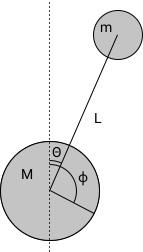

In [3]:
import numpy as np
from numpy import sin, cos, pi

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
plt.style.use('seaborn-whitegrid')

In [4]:
def solve(initial_state, times, integrate_func, derivative_func):
    """
    Solves the initial-value problem of the first order ODEs
    :param initial_state: initial state
    :param times: a sequence of time points for which to solve
    :param integrate_func: calculates the next state
    :param derivative_func: computes derivatives of each state component
    :return:
    """
    dt = times[1] - times[0]
    states = [initial_state]
    for step, t in enumerate(times):
        states.append(integrate_func(states[-1], step, t, dt, derivative_func))
    return np.array(states)

def integrate_rk4(state, step, t, dt, dydx_func):
    """
    Fourth-order Runge-Kutta method.
    Source: https://www.geeksforgeeks.org/runge-kutta-4th-order-method-solve-differential-equation/
    :param step:
    :param state:
    :param t:
    :param dt:
    :param dydx_func:
    :return:
    """
    k1 = dydx_func(state, step, t, dt)
    k2 = dydx_func([v + d * dt / 2 for v, d in zip(state, k1)], step, t, dt)
    k3 = dydx_func([v + d * dt / 2 for v, d in zip(state, k2)], step, t, dt)
    k4 = dydx_func([v + d * dt for v, d in zip(state, k3)], step, t, dt)
    return [v + (k1_ + 2 * k2_ + 2 * k3_ + k4_) * dt / 6 for v, k1_, k2_, k3_, k4_ in zip(state, k1, k2, k3, k4)]

In [8]:
r = 0.12 # radius: R [m]
l = 0.2 # rod of length (L) [kg]
M = 0.1 # wheel mass: M [kg]
m = 1.1 #mass (m), attached to wheel [kg]
g = 9.8 #[m/s2]

I = 0.5 * M * r # moment of inertia $ I = \frac{1}{2} \cdot M \cdot R $) 

def derivate(state, step, t, dt):
    dth, th, dphi, phi = state

    _dphi = (m * l * r * dth ** 2 * sin(th) - m * g * r * sin(th) * cos(th)) / (m * r ** 2 * sin(th) ** 2 + I)
    _dth = (g * sin(th) - r * _dphi * cos(th)) / l

    return [_dth, dth, _dphi, dphi]

In [9]:
times = np.linspace(0, 10, 500)
solution = solve([0.0, pi / 12, .0, .0], times, integrate_rk4, derivate)

def render(solution):
    theta = solution[:, 1]
    phi = solution[:, 3]

    wheel_x = phi * r

    spot_r = 0.7 * r
    wheel_spot_x = wheel_x + spot_r * cos(phi - pi / 2)
    wheel_spot_y = r - spot_r * sin(phi - pi / 2)

    mass_x = wheel_x + l * cos(theta - pi / 2)
    mass_y = r - l * sin(theta - pi / 2)

    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
    ax.set_aspect('equal')
    ax.grid(True)

    line, = ax.plot([], [], 'k-', lw=2)
    wheel = plt.Circle((0.0, r), r, color='black', fill=False, lw=2)
    wheel_spot = plt.Circle((0.0, spot_r), 0.02, color='red')
    mass = plt.Circle((0.0, 0.0), 0.1, color='black')


    def init():
        return []


    def animate(i):
        wheel.set_center((wheel_x[i], r))
        wheel_spot.set_center((wheel_spot_x[i], wheel_spot_y[i]))
        mass.set_center((mass_x[i], mass_y[i]))
        line.set_data([wheel_x[i], mass_x[i]], [r, mass_y[i]])
        patches = [line, ax.add_patch(wheel), ax.add_patch(wheel_spot), ax.add_patch(mass)]
        return patches


    ani = animation.FuncAnimation(fig, animate, np.arange(1, len(solution)),interval=25, blit=True, init_func=init)    
    plt.close(fig)
    return ani

ani = render(solution)

### following cell generates a gif animation of the robot model
#### runs for ~2'

In [10]:
%time ani.save('free_robot.gif', writer='imagemagick', fps=24)

CPU times: user 1min 26s, sys: 256 ms, total: 1min 26s
Wall time: 1min 49s


![](./free_robot.gif)

## Adding feedback loop for angle and velocity control

Upright position and the velocity can be controlled with the following feedback loops.

![feedback.png](feedback.png)


In this setup it finds new balance point if the velocity keeps being different for a long time.
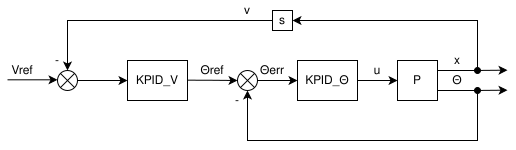

In [11]:
class PIDController:
    def __init__(self, k_p, k_d, k_i, target, init_value=0.0):
        self.Kp = k_p
        self.Kd = k_d
        self.Ki = k_i
        self.target = target
        self.lastValue = init_value
        self.integral_error = 0.0

    def get_control(self, value, dt):
        """
            Returns PID control.
            Derivative spike is mitigated by dError/dt = -dInput/dt
            see: http://brettbeauregard.com/blog/2011/04/improving-the-beginner%e2%80%99s-pid-derivative-kick/
        """
        error = self.target - value

        derivative = -(value - self.lastValue) / dt

        self.lastValue = value
        self.integral_error += error * dt
        return self.Kp * error + self.Kd * derivative + self.Ki * self.integral_error

    def set_target(self, target):
        self.target = target

In [12]:
b1 = 0.01 # Friction coefficient due to rotation of the body
b2 = 0.01 # Friction coefficient due to rotation of the wheel

th_pid = PIDController(k_p=10.0, k_d=0.5, k_i=1.0, target=0.0)
velocity_pid = PIDController(k_p=0.002, k_d=0.0, k_i=0.001, target=0.0)

def limit(v, lim):
    if v > lim:
        return lim
    elif v < -lim:
        return -lim
    else:
        return v

def derivate_velocity_pid(state, step, t, dt):
    dth, th, dphi, phi = state

    th_target = velocity_pid.get_control(dphi, dt)
    th_pid.set_target(th_target)
    u = -th_pid.get_control(th, dt)
    u = limit(u, 10)

    s = sin(th)
    c = cos(th)

    _dphi = (m * r * (l * dth ** 2 * s + b1 * dth * c - g * s * c) - b2 * dphi + u) / (I + m * r ** 2 * s ** 2)
    _dth = (g * s - r * _dphi * c - b1 * dth) / l

    return [_dth, dth, _dphi, dphi]


In [13]:
solution = solve([0.0, pi / 12, .0, .0], times, integrate_rk4, derivate_velocity_pid)
ani = render(solution)

In [14]:
%time ani.save('velocity_pid.gif', writer='imagemagick', fps=24)

CPU times: user 1min 24s, sys: 280 ms, total: 1min 24s
Wall time: 1min 46s


![](./velocity_pid.gif)

## Position control

The diagram below shows how to control robot's position

![feedback_w_ctrl.png](feedback_w_ctrl.png)
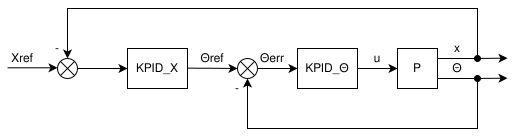

In [10]:
th_pid = PIDController(k_p=40.0, k_d=20.0, k_i=0.0, target=0.0)
position_pid = PIDController(k_p=0.07, k_d=0.07, k_i=0.0, target=0.0)

def derivate_position_pid(state, step, t, dt):
    dth, th, dphi, phi = state

    th_target = position_pid.get_control(phi, dt)
    th_pid.set_target(th_target)
    u = -th_pid.get_control(th, dt)
    u = limit(u, 10)

    s = sin(th)
    c = cos(th)

    _dphi = (m * r * (l * dth ** 2 * s + b1 * dth * c - g * s * c) - b2 * dphi + u) / (I + m * r ** 2 * s ** 2)
    _dth = (g * s - r * _dphi * c - b1 * dth) / l

    return [_dth, dth, _dphi, dphi]

solution = solve([0.0, pi / 12, .0, .0], times, integrate_rk4, derivate_position_pid)
ani = render(solution)


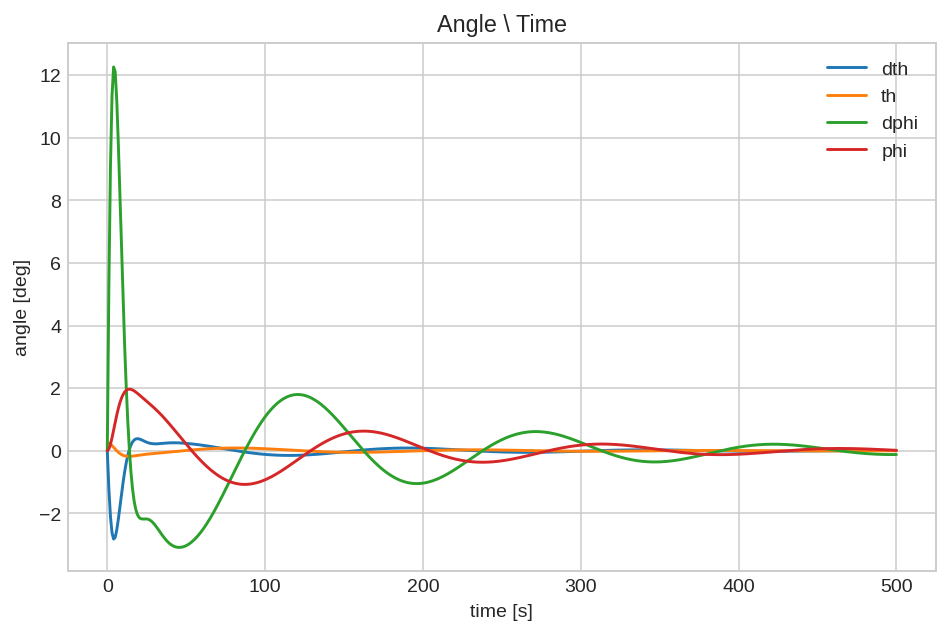

In [55]:
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams['figure.dpi'] = 140
plt.plot(solution, label=["dth", "th", "dphi", "phi"])
plt.title("Angle \ Time")
plt.xlabel("time [s]")
plt.ylabel("angle [deg]")
plt.legend(loc="upper right")
plt.show()

In [11]:
%time ani.save('position_pid.gif', writer='imagemagick', fps=24)

CPU times: user 1min 25s, sys: 252 ms, total: 1min 26s
Wall time: 1min 46s


![](./position_pid.gif)

![plotPID](plotPID.png)

Feel free to create your own controller by implementing `derivate_XXX` function

## References
- [Source code of a real robot](https://github.com/zjor/balancing-robot)
- [Project description](https://hackaday.io/project/180126-self-balancing-robot-for-humans)
- [Video of a balancing robot](https://www.youtube.com/watch?v=1LGBiAcChJg)
- [Python code for simulations](https://github.com/zjor/snippets/tree/master/python/ode_solver)